## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
!pip install plotly

In [263]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [264]:
# Opening JSON file 
f = open('./complaints.json','r') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [265]:
df.head(2)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


## Data preparation

In [266]:
# Inspect the dataframe to understand the given data.
df['_source.complaint_what_happened'].isna().sum()

0

In [267]:
df.shape, df[df['_source.complaint_what_happened'] == ''].shape

((78313, 22), (57241, 22))

In [268]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [269]:
#Assign new column names
columnNames = [ col.removeprefix('_source.') if col.startswith('_source.') else col for col in df.columns]
df.columns = columnNames
df.head(2)

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [270]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'] != ''].reset_index()
df.shape

(21072, 23)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [271]:
!pip install swifter

In [272]:
import swifter
import re

In [273]:
df['complaint_what_happened'][0]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

In [274]:
# Write your function here to clean the text and remove all the unnecessary elements.
newComplaintData = df['complaint_what_happened'].swifter.apply(lambda x: re.sub(r'\s{2,}', ' ', re.sub(r'(?:x{2,})|[^A-z\d\s\.\-]+|\b\d+(?:\.\d+)?\b', '', x,flags=re.I, count=100000), count=100000).lower())

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [275]:
print('****Before cleaning*******')
print(df['complaint_what_happened'][19])
print('\n*********after cleaning*******')
print(newComplaintData[19])

****Before cleaning*******
I made a purchase with XXXX XXXX XXXX on XX/XX/2019 in the amount of {$38.00}. I was charged twice for this transaction. I placed a disputes case with Chase bank on XX/XX/2019 when I noticed the charge on my account. I called back on Sunday, XX/XX/2019 about the provisional credit for the charge and again on Monday, XX/XX/2019. I was told the charge had to post before a provisional credit could be provided. I used my debt card on Monday, XX/XX/2019 then tried to use it again but it would not work. I went to Chase bank on XXXX XXXX XXXX in XXXX XXXX, Nevada and was told that my account was closed due to fraudulent activity. I was shocked because I had not reported fraud on my account. I later found out that I was being accused by the disputes department of placing a fraudulent disputes case for the duplicate charge from XXXX XXXX  XXXX. I later contacted XXXX XXXX  XXXX again and was told that they DID see a duplicate charge and would credit my account within 

In [276]:
#Write your function to Lemmatize the texts
def lematize_pos(text):
    doc = nlp(text)
    lemma_complaint = " ".join([token.lemma_ for token in doc])
    pos_filtered = " ".join([token.lemma_ for token in doc if token.pos_ == "NOUN"])
    return lemma_complaint, pos_filtered

In [277]:
lematized_pos_results  = newComplaintData.swifter.apply(lematize_pos)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [278]:
lemma_complaint = []
pos_complaint =[]
for l_c, p_f in lematized_pos_results:
    lemma_complaint.append(l_c)
    pos_complaint.append(p_f)

In [279]:
lematized_pos_results[1]

('I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . change my anniversary date from to without my consent have the recording of the agent who be mislead I .',
 'card agent anniversary date agent information order account anniversary date consent recording agent')

In [311]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({"complaints_clean" : newComplaintData,
                         "complaint_lemmatized" : lemma_complaint,
                         "complaint_POS_removed" : pos_complaint
                        })
df_clean.reset_index(drop = True, inplace = True)

In [312]:
df_clean.head(5)

,complaints_clean,complaint_lemmatized,complaint_POS_removed
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop debt verification statement ...
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...
2,chase card was reported on . however fraudulen...,chase card be report on . however fraudulent a...,chase card application identity consent servic...
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son check chase account fund chase bank accoun...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




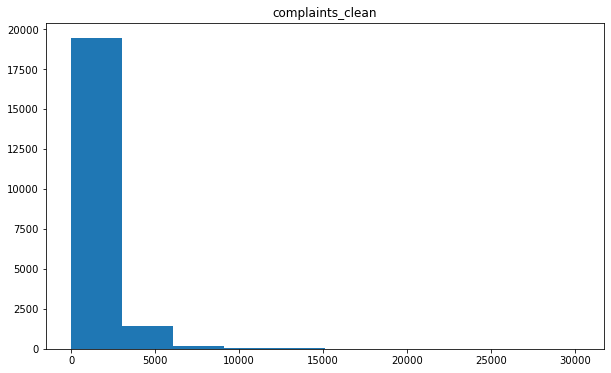

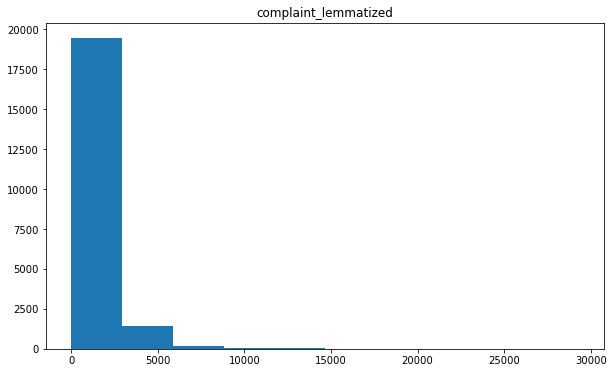

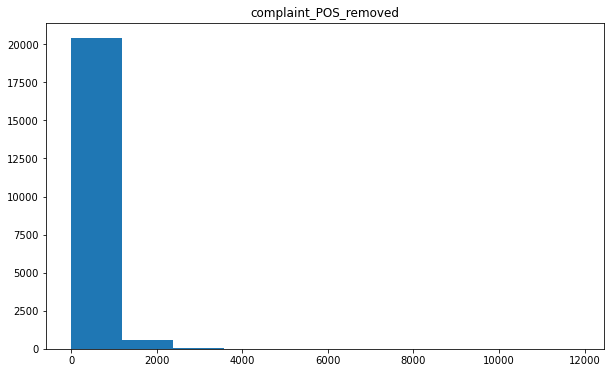

In [313]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
plt.hist(df_clean['complaints_clean'].str.len())
plt.title('complaints_clean')
plt.show()
plt.figure(figsize=(10,6))
plt.title('complaint_lemmatized')
plt.hist(df_clean['complaint_lemmatized'].str.len())
plt.show()
plt.figure(figsize=(10,6))
plt.title('complaint_POS_removed')
plt.hist(df_clean['complaint_POS_removed'].str.len())
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [174]:
!pip install wordcloud

In [314]:
from wordcloud import WordCloud, STOPWORDS

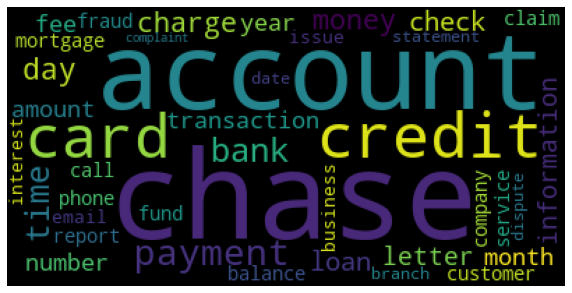

In [315]:
word_cloud = WordCloud(collocations = False, max_words = 40, random_state = 100).generate(" ".join(df_clean["complaint_POS_removed"]))
plt.figure(figsize = (10, 10))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [316]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [317]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def nGram(data, n):
    vec = CountVectorizer(ngram_range=(n,n)).fit(data)
    bow = vec.transform(data)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key = lambda x: x[1], reverse=True)

In [318]:
#Print the top 10 words in the unigram frequency
unigrams = nGram(df_clean["complaint_POS_removed"], 1)
unigrams[:30]

[('chase', 63592),
 ('account', 47227),
 ('credit', 32703),
 ('card', 30407),
 ('payment', 21290),
 ('bank', 18587),
 ('time', 16267),
 ('day', 13237),
 ('charge', 12253),
 ('money', 11992),
 ('loan', 10982),
 ('check', 10420),
 ('letter', 9671),
 ('information', 9663),
 ('fee', 8956),
 ('number', 8636),
 ('transaction', 8635),
 ('month', 8587),
 ('year', 8420),
 ('amount', 8303),
 ('customer', 8181),
 ('mortgage', 8117),
 ('balance', 7778),
 ('company', 7620),
 ('phone', 7578),
 ('service', 7460),
 ('fund', 7046),
 ('report', 7012),
 ('fraud', 6725),
 ('claim', 6670)]

In [319]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = nGram(df_clean["complaint_POS_removed"], 2)
bigrams[:30]

[('credit card', 12885),
 ('credit report', 3874),
 ('chase credit', 3769),
 ('account chase', 3698),
 ('checking account', 3323),
 ('chase account', 3129),
 ('chase bank', 3075),
 ('customer service', 2996),
 ('account account', 2692),
 ('bank account', 2305),
 ('card chase', 2036),
 ('debit card', 2022),
 ('chase card', 1963),
 ('credit score', 1723),
 ('card account', 1698),
 ('phone call', 1622),
 ('payment payment', 1607),
 ('account credit', 1578),
 ('chase chase', 1440),
 ('letter chase', 1428),
 ('money account', 1426),
 ('chase customer', 1374),
 ('interest rate', 1304),
 ('payment chase', 1272),
 ('business day', 1263),
 ('phone number', 1254),
 ('card card', 1224),
 ('account number', 1223),
 ('card company', 1152),
 ('card credit', 1151)]

In [320]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = nGram(df_clean["complaint_POS_removed"], 3)
trigrams[:30]

[('chase credit card', 2604),
 ('credit card account', 1048),
 ('credit card company', 1004),
 ('credit card chase', 914),
 ('chase customer service', 592),
 ('credit card credit', 563),
 ('inquiry credit report', 557),
 ('chase checking account', 477),
 ('card credit card', 448),
 ('account credit card', 437),
 ('charge credit card', 375),
 ('credit report credit', 373),
 ('checking account chase', 371),
 ('chase bank account', 356),
 ('customer service representative', 352),
 ('account chase account', 352),
 ('credit reporting agency', 349),
 ('account credit report', 336),
 ('credit card payment', 330),
 ('credit reporting act', 317),
 ('credit report chase', 292),
 ('credit card card', 284),
 ('chase auto finance', 278),
 ('chase card service', 276),
 ('credit card balance', 276),
 ('phone call chase', 255),
 ('victim identity theft', 254),
 ('credit card charge', 249),
 ('payment credit card', 245),
 ('chase account chase', 244)]

In [321]:
# Top 10 Unigram, Bigram and Trigram
top10unigrams = [ unigrams[i][0] for i in range(10)]
print('------------Top 10 unigrams---------------\n',", ".join(top10unigrams))
top10bigrams = [ bigrams[i][0] for i in range(10)]
print('\n---------------Top 10 bigrams---------------\n',", ".join(top10bigrams))
top10trigrams = [ trigrams[i][0] for i in range(10)]
print('\n-------------Top 10 trigrams-----------------\n',", ".join(top10trigrams))

------------Top 10 unigrams---------------
 chase, account, credit, card, payment, bank, time, day, charge, money

---------------Top 10 bigrams---------------
 credit card, credit report, chase credit, account chase, checking account, chase account, chase bank, customer service, account account, bank account

-------------Top 10 trigrams-----------------
 chase credit card, credit card account, credit card company, credit card chase, chase customer service, credit card credit, inquiry credit report, chase checking account, card credit card, account credit card


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [322]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [323]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.complaints_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [324]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [325]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [326]:
transformed = nmf_model.fit_transform(dtm)
len(tfidf.get_feature_names())

15351

In [327]:
#Print the Top15 words for each of the topics
comps = nmf_model.components_
words = np.array(tfidf.get_feature_names())
topic_top15_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = comps[i].argsort()[::-1][:15]
    topic_top15_words.iloc[i] = words[ix]
topic_top15_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 1,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,removed,debt
Topic 2,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,years,bank,sale,morgan,rate,jp
Topic 3,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 4,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,monthly,charged


In [337]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
doc_topic = pd.DataFrame(transformed, columns = [f'Topic {i}' for i in range(1, num_topics+1)])
doc_topic["topic"] = doc_topic.apply(lambda x : np.argmax(x), axis = 1)
df_clean['Topic'] = doc_topic["topic"] 
df_clean['Topic_Num'] = doc_topic["topic"] 

In [338]:
df_clean.head()

,complaints_clean,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic,topic,Topic_Num
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2,2,2
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0,0,0
2,chase card was reported on . however fraudulen...,chase card be report on . however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1,1,1
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1,1,1
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3,3,3


In [339]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaints_clean,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic,topic,Topic_Num
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0,0,0
8,on i made a payment to an online retailer usin...,on I make a payment to an online retailer use ...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0,0,0
18,chase sent me an email today with the innocuou...,chase send I an email today with the innocuous...,chase email today title information change cha...,chase email today title information change cha...,0,0,0
16,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and be neve...,sofa love seat table chair debit card claim fu...,sofa love seat table chair debit card claim fu...,0,0,0
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,0,0,0
2,chase card was reported on . however fraudulen...,chase card be report on . however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1,1,1
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1,1,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1,1,1
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1,1,1
11,i have reached out to several times in attempt...,I have reach out to several time in attempt to...,time attempt inquiry creditor inquiry report a...,time attempt inquiry creditor inquiry report a...,1,1,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [340]:
#Create the dictionary of Topic names and Topics
Topic_names = {   0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others' }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [341]:
df_clean.head()

,complaints_clean,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic,topic,Topic_Num
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgage/Loan,2,2
1,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Bank Account services,0,0
2,chase card was reported on . however fraudulen...,chase card be report on . however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,Credit card or prepaid card,1,1
3,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card or prepaid card,1,1
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Theft/Dispute Reporting,3,3


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [342]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaints_clean", "Topic_Num"]]

In [343]:
training_data.head()

,complaints_clean,Topic_Num
0,good morning my name is and i appreciate it if...,2
1,i upgraded my card in and was told by the agen...,0
2,chase card was reported on . however fraudulen...,1
3,on while trying to book a ticket i came across...,1
4,my grand son give me check for i deposit it in...,3


In [344]:
training_data.shape

(21072, 2)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [345]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

In [346]:
X_train, X_test, y_train, y_test = train_test_split(training_data.complaints_clean, training_data.Topic_Num, train_size=0.8, random_state=40)

In [347]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16857, 27283) (16857,)
(4215, 27283) (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [366]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def find_performance(y_test, y_pred):
    print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
    print(f"Precision: {metrics.precision_score(y_test,y_pred, average='weighted')}")
    print(f"Recall: {metrics.recall_score(y_test,y_pred, average='weighted')}")
    print(f"F1_score: {metrics.f1_score(y_test,y_pred, average='weighted')}")


---------------Logistic Regression-------------

Accuracy: 0.9501779359430605
Precision: 0.9507395861215334
Recall: 0.9501779359430605
F1_score: 0.9500440251783793


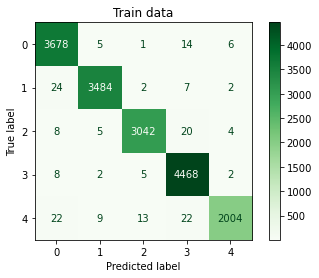

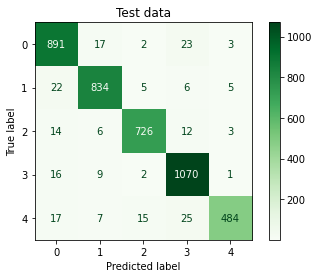

In [364]:
# logistic regression
print("\n---------------Logistic Regression-------------\n")
lr = LogisticRegression(random_state=42, max_iter=500)
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
find_performance(y_test, y_test_pred)
metrics.plot_confusion_matrix(lr, X_train, y_train, cmap="Greens")
plt.title("Train data")
plt.show()
metrics.plot_confusion_matrix(lr, X_test, y_test, cmap="Greens") 
plt.title("Test data")
plt.show()


---------------Decision Tree classifier-------------

Accuracy: 0.7788849347568209
Precision: 0.7788865950087563
Recall: 0.7788849347568209
F1_score: 0.7788042227035363


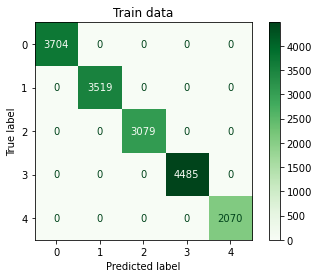

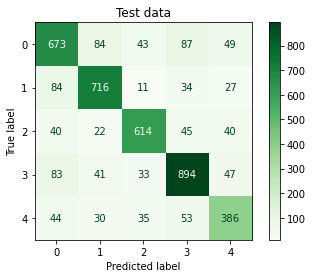

In [368]:
# Decision tree
print("\n---------------Decision Tree classifier-------------\n")
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
find_performance(y_test, y_test_pred)
metrics.plot_confusion_matrix(tree, X_train, y_train, cmap="Greens")
plt.title("Train data")
plt.show()
metrics.plot_confusion_matrix(tree, X_test, y_test, cmap="Greens") 
plt.title("Test data")
plt.show()


---------------Random Forest-------------

Accuracy: 0.842467378410439
Precision: 0.8500159655480966
Recall: 0.842467378410439
F1_score: 0.8387964481529114


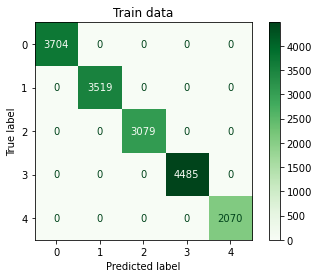

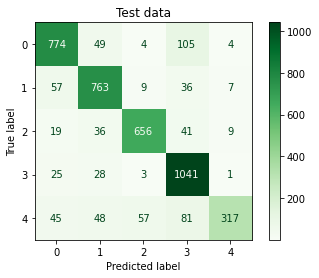

In [369]:
# Random Forest
print("\n---------------Random Forest-------------\n")
tree = RandomForestClassifier(random_state=42)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
find_performance(y_test, y_test_pred)
metrics.plot_confusion_matrix(tree, X_train, y_train, cmap="Greens")
plt.title("Train data")
plt.show()
metrics.plot_confusion_matrix(tree, X_test, y_test, cmap="Greens") 
plt.title("Test data")
plt.show()